In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main/")
import scanpy as sc
import pandas as pd
import numpy as np
import os
import networkx as nx
import switch2 as sw
from itertools import chain

In [2]:
os.chdir("../../../DATA/H3k4me3/")

Preprocess

In [3]:
# rna = sc.read_h5ad("rna-pp.h5ad")
# atac = sc.read_h5ad("peakMat.h5ad")
# atac.obs_names = [i.split("-")[0] for i in atac.obs_names]
# comm = list(set(rna.obs_names) & set(atac.obs_names))
# atac = atac[comm]
# rna = rna[comm]
# atac.obsm["spatial"] = rna.obsm["spatial"].copy()
# (rna.obs_names==atac.obs_names).all()

In [4]:
# sw.pp.get_gene_annotation(rna, 
#                           gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
#                           gtf_by="gene_name",
#                           drop_na=True
#                           )

In [5]:
# rna.layers["counts"] = rna.X.copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=3000, flavor="seurat_v3", layer="counts")

In [6]:
# split = atac.var_names.str.split(r"[:-]")
# atac.var["chrom"] = split.map(lambda x: x[0])
# atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
# atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# ## print(i.var)

In [7]:
# print(atac.shape[1])
# sc.pp.filter_genes(atac, min_cells=50)
# print(atac.shape[1])

In [8]:
# guidance = sw.pp.rna_anchored_guidance_graph(rna, atac)
# len(atac.var[atac.var["highly_variable"]==True])

In [9]:
# guidance_hvf = guidance.subgraph(chain(
#    rna.var.query("highly_variable").index,
#    atac.var.query("highly_variable").index
# )).copy()
# # nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [10]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")

In [11]:
rna = sc.read_h5ad("rna-pp.h5ad")
atac = sc.read_h5ad("atac-pp.h5ad")
guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

Training

In [12]:
sw.pp.setup_data(
    rna, "NB", # Negative binomial distribution
    use_highly_variable=True,
    use_layer="counts",
)
sw.pp.setup_data(
    atac, "Poisson", # Poisson distribution
    use_highly_variable=True, 
)

In [13]:
sw.pp.cal_spatial_net(rna, cutoff=55, model="Radius")
sw.pp.cal_spatial_net(atac, cutoff=55, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 111738 edges, 9542 spots.
11.7101 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 111738 edges, 9542 spots.
11.7101 neighbors per spot on average.


In [14]:
model = sw.SWITCH(adatas={"rna": rna, "atac": atac},
                  vertices=sorted(guidance_hvf.nodes),
                  h_depth_dsc=2,)

- INFO - Set random seed to 0
- INFO - GPU available: True, used device: GPU 1


In [ ]:
model.compile()

In [16]:
model.pretrain(adatas={"rna": rna, "atac": atac},
               graph=guidance_hvf, 
               max_epochs=2000,
               dsc_k=4,
               warmup=True)

- INFO - Prepare data for training.
- INFO - Pretraining with full batch.
Epoch 2000/2000: 100%|██████████| 2000/2000 [06:20<00:00,  5.26it/s, dsc_loss=0.692, gen_loss=0.404]
- INFO - Model pretrain done.


In [17]:
model.train(adatas={"rna": rna, "atac": atac},
            graph=guidance_hvf,
            max_epochs=1000,
            dsc_k=8,
            warmup=True,
            warmup_kwargs={"gamma":0.7})

- INFO - Training with full batch.
Epoch 1000/1000: 100%|██████████| 1000/1000 [08:39<00:00,  1.93it/s, dsc_loss=0.693, gen_loss=0.868, cycle_loss=0.407, align_loss=0.747]
- INFO - Model training done.


In [101]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [102]:
combined = sc.concat([rna, atac], label="omics")
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined, min_dist=0.3)

In [159]:
sc.tl.leiden(adata=combined, resolution=.8, key_added="leiden", random_state=666)
print(len(set(combined.obs["leiden"])))

16


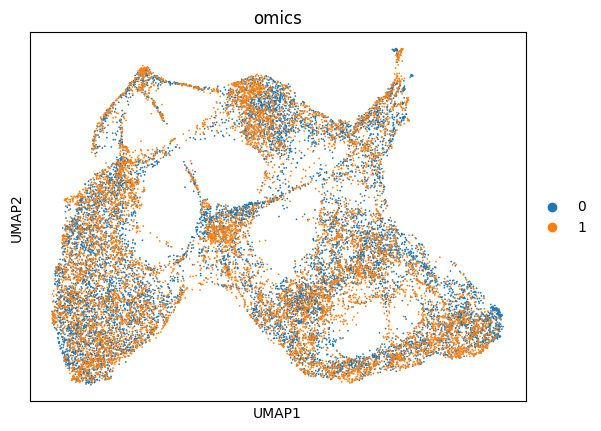

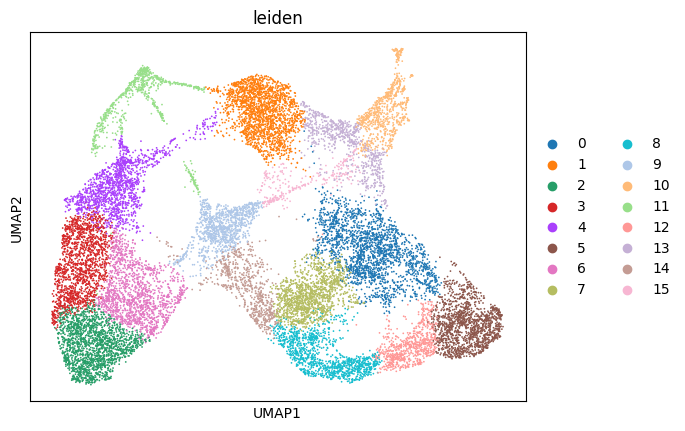

In [160]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="leiden")

In [161]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

In [162]:
def exchCoor(adata):
    spatial = pd.DataFrame(adata.obsm["spatial"])
    spatial.columns = ["x","y"]
    spatial["x"] = [-1*i for i in list(spatial["x"])]
    # spatial["y"] = [-1*i for i in list(spatial["y"])]

    new_spatial = np.array(spatial[["x","y"]])
    adata.obsm["spatial"] = new_spatial
exchCoor(t_rna)
exchCoor(t_atac)

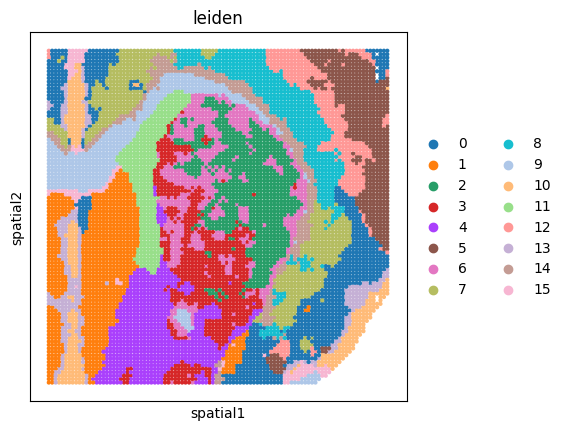

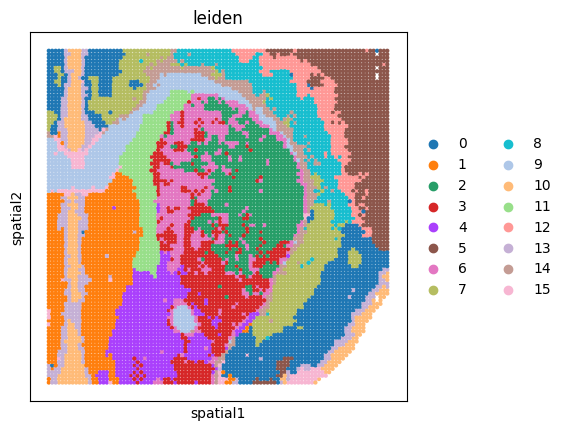

In [163]:
sc.pl.spatial(t_atac, color="leiden",spot_size=34)
sc.pl.spatial(t_rna, color="leiden",spot_size=34)

In [166]:
sw.metrics.foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])

0.03957221679344496

In [165]:
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# cluster = pd.DataFrame(combined.obs["leiden"])
# cluster.to_csv("rep1/SWITCH_cluster.csv")